# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
#%matplotlib notebook
#%pylab
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [3]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=901)
    return corrected_lc

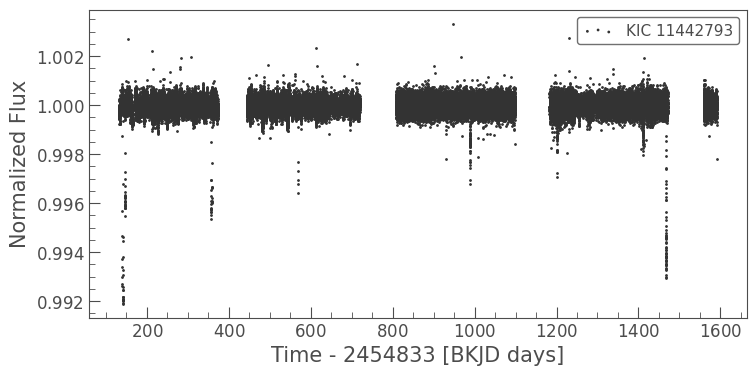

In [4]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.scatter();

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


In [5]:
# YOUR CODE HERE

#Get periodogram
period_vals = np.arange(50, 500.01, .01)
pg = clc.to_periodogram(method='bls', period=period_vals)

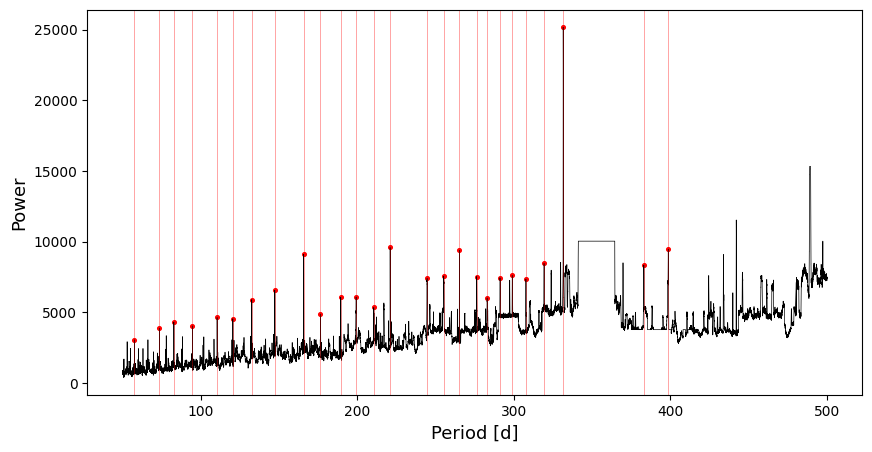

In [6]:
#Find peaks
# - Use prominence as a filter
# - Make it so that peaks have to pe at least 1d apart
peak_res = find_peaks( pg.power.value, prominence=2500, distance=5//.01)[0]

#Disregrd peaks near 365d and larger than 400d
bad_range = np.array([340, 370])
filtered_peaks = []
for peak in peak_res:

    bool1 = pg.period[peak].value > bad_range[0]
    bool2 = pg.period[peak].value < bad_range[1]

    if np.all([bool1, bool2]):
        continue
    elif pg.period[peak].value > 400:
        continue
    else:
        filtered_peaks.append(peak)



#Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot( pg.period, pg.power, c='k', lw=.5 )
for peak in filtered_peaks:
    ax.axvline( pg.period[peak].value, color='r', alpha=.5, lw=.5 )
    ax.scatter( [pg.period[peak].value], [pg.power[peak].value], color='r', s=7 )

ax.set_ylabel('Power', fontsize=13)
ax.set_xlabel('Period [d]', fontsize=13)

plt.show()

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [7]:
# YOUR CODE HERE
candidates = pg.period[filtered_peaks].value
power_vals = pg.power[filtered_peaks].value
tt_vals = pg.transit_time[filtered_peaks].value

In [8]:
sort_ind = np.argsort(power_vals)[::-1]

period1 = candidates[sort_ind]
power1 = power_vals[sort_ind]
tt1 = tt_vals[sort_ind]

In [9]:
period1

array([331.57, 221.04, 398.68, 265.26, 165.78, 319.35, 383.07, 299.02,
       255.23, 276.29, 291.19, 244.67, 307.74, 147.36, 199.33, 189.47,
       283.  , 132.63, 210.6 , 176.52, 110.52, 120.57,  82.89,  94.74,
        73.68,  57.67])

# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [10]:
# YOUR CODE HERE
bad_ind = []

#Sort by period
sort_ind = np.argsort(period1)[::-1]
sorted_period = period1[sort_ind]
sorted_power = power1[sort_ind]
sorted_tt = tt1[sort_ind]

fracs = [1/2, 1/3]
tol = .5
for i in range(len(sorted_period)):
    for f in fracs:
        mask = np.abs( sorted_period - f*sorted_period[i] ) < tol
        ind = np.argwhere(mask).T[0]
        
        assert len(ind) < 2
        
        if len(ind) == 1:
            bad_ind.append(ind[0])
        
    if i in bad_ind:
        continue


refined_peaks = np.delete( sorted_period, bad_ind )
refined_power = np.delete( sorted_power, bad_ind )
refined_tt = np.delete( sorted_tt, bad_ind )

#Sort by power
sort_ind = np.argsort(refined_power)[::-1]
refined_peaks = refined_peaks[sort_ind] 
refined_power = refined_power[sort_ind]
refined_tt = refined_tt[sort_ind]

In [11]:
refined_peaks

array([331.57, 221.04, 398.68, 265.26, 319.35, 383.07, 299.02, 255.23,
       276.29, 291.19, 244.67, 307.74, 147.36, 189.47, 283.  , 210.6 ,
       176.52, 120.57,  57.67])

In [12]:
bins = np.array([0., 100., 200., 300., 400.])
bin_ind = np.digitize(refined_peaks, bins)

In [13]:
bin_labels = ['0-100', '100-200', '200-300', '300-400']

binned_period = []
binned_power = []
binned_tt = []

for _ in range(len(bin_labels)):
    binned_period.append([])
    binned_power.append([])
    binned_tt.append([])

for i in range(len(bin_ind)):
    binned_period[ bin_ind[i]-1 ].append( refined_peaks[i] )
    binned_power[ bin_ind[i]-1 ].append( refined_power[i] )
    binned_tt[ bin_ind[i]-1 ].append( refined_tt[i] )

#Only take top 4
for i in range(len(bin_labels)):
    binned_period[i] = binned_period[i][:4]
    binned_power[i] = binned_power[i][:4]
    binned_tt[i] = binned_tt[i][:4]

In [14]:
from tabulate import tabulate

print_binned_period = np.full( (4, 4), np.nan )
for i in range(len(binned_period)):
    print_binned_period[i, :len(binned_period[i])] = binned_period[i]
    
print(tabulate(print_binned_period.T, headers=bin_labels) )

  0-100    100-200    200-300    300-400
-------  ---------  ---------  ---------
  57.67     147.36     221.04     331.57
 nan        189.47     265.26     398.68
 nan        176.52     299.02     319.35
 nan        120.57     255.23     383.07


# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

In [16]:
# YOUR CODE HERE
from tqdm import tqdm

period_tot = []
power_tot = []
tt_tot = []

for i in range(len(binned_period)):
    for j in range(len(binned_period[i])):
        period_tot.append( binned_period[i][j] )
        power_tot.append( binned_power[i][j] )
        tt_tot.append( binned_tt[i][j] )


#Sort by power
sort_ind = np.argsort(power_tot)[::-1]  
period_tot = np.array(period_tot)[sort_ind]
power_tot = np.array(power_tot)[sort_ind]
tt_tot = np.array(tt_tot)[sort_ind]



#For each peak candidate:
#1. Create a new periodogram with a range of periods around the peak
#3. Compute the stats (period, tramsit time, etc.) and transit model
#4. Subtract the transit model from the original light curve
#5. Repeat

final_period = []
final_power = []
final_duration = []
final_tt = []
final_models  = []

pg_tot = clc.to_periodogram(method='bls', frequency_factor=5000)
clc_tot = lk.LightCurve(time=pg_tot.time, flux=pg_tot.flux)

clc_new = clc_tot.copy()

for peak in tqdm(period_tot):
    period_vals = np.arange(peak-5, peak+5, 1e-3)
    pg_i = clc_new.to_periodogram(method='bls', period=period_vals)
    
    final_period.append( pg_i.period_at_max_power.value )
    final_power.append( pg_i.max_power.value )
    final_duration.append( pg_i.duration_at_max_power.value )
    
    stats = pg_i.compute_stats(period=pg_i.period_at_max_power.value, 
                               duration=pg_i.duration_at_max_power.value, 
                               transit_time=pg_i.transit_time_at_max_power.value)
    final_tt.append( stats['transit_times'].value )
    
    final_models.append( pg_tot.get_transit_model( period=final_period[-1], 
                                                   duration=final_duration[-1], 
                                                   transit_time=pg_i.transit_time_at_max_power.value 
                                                 ) 
                       )
    clc_new = clc_new - final_models[-1]

100%|██████████| 13/13 [01:54<00:00,  8.83s/it]


In [17]:
final_period

[331.56999999982577,
 221.13199999999026,
 393.6799999999307,
 264.0149999998684,
 322.23299999976,
 383.11699999981437,
 300.80399999979005,
 254.382999999979,
 147.32100000000432,
 184.8129999999739,
 176.53399999999877,
 117.74699999999633,
 59.73399999998202]

In [18]:
#Real periods
[59.73667, 91.93913, 124.9144, 210.60697, 331.60059]

[59.73667, 91.93913, 124.9144, 210.60697, 331.60059]

# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

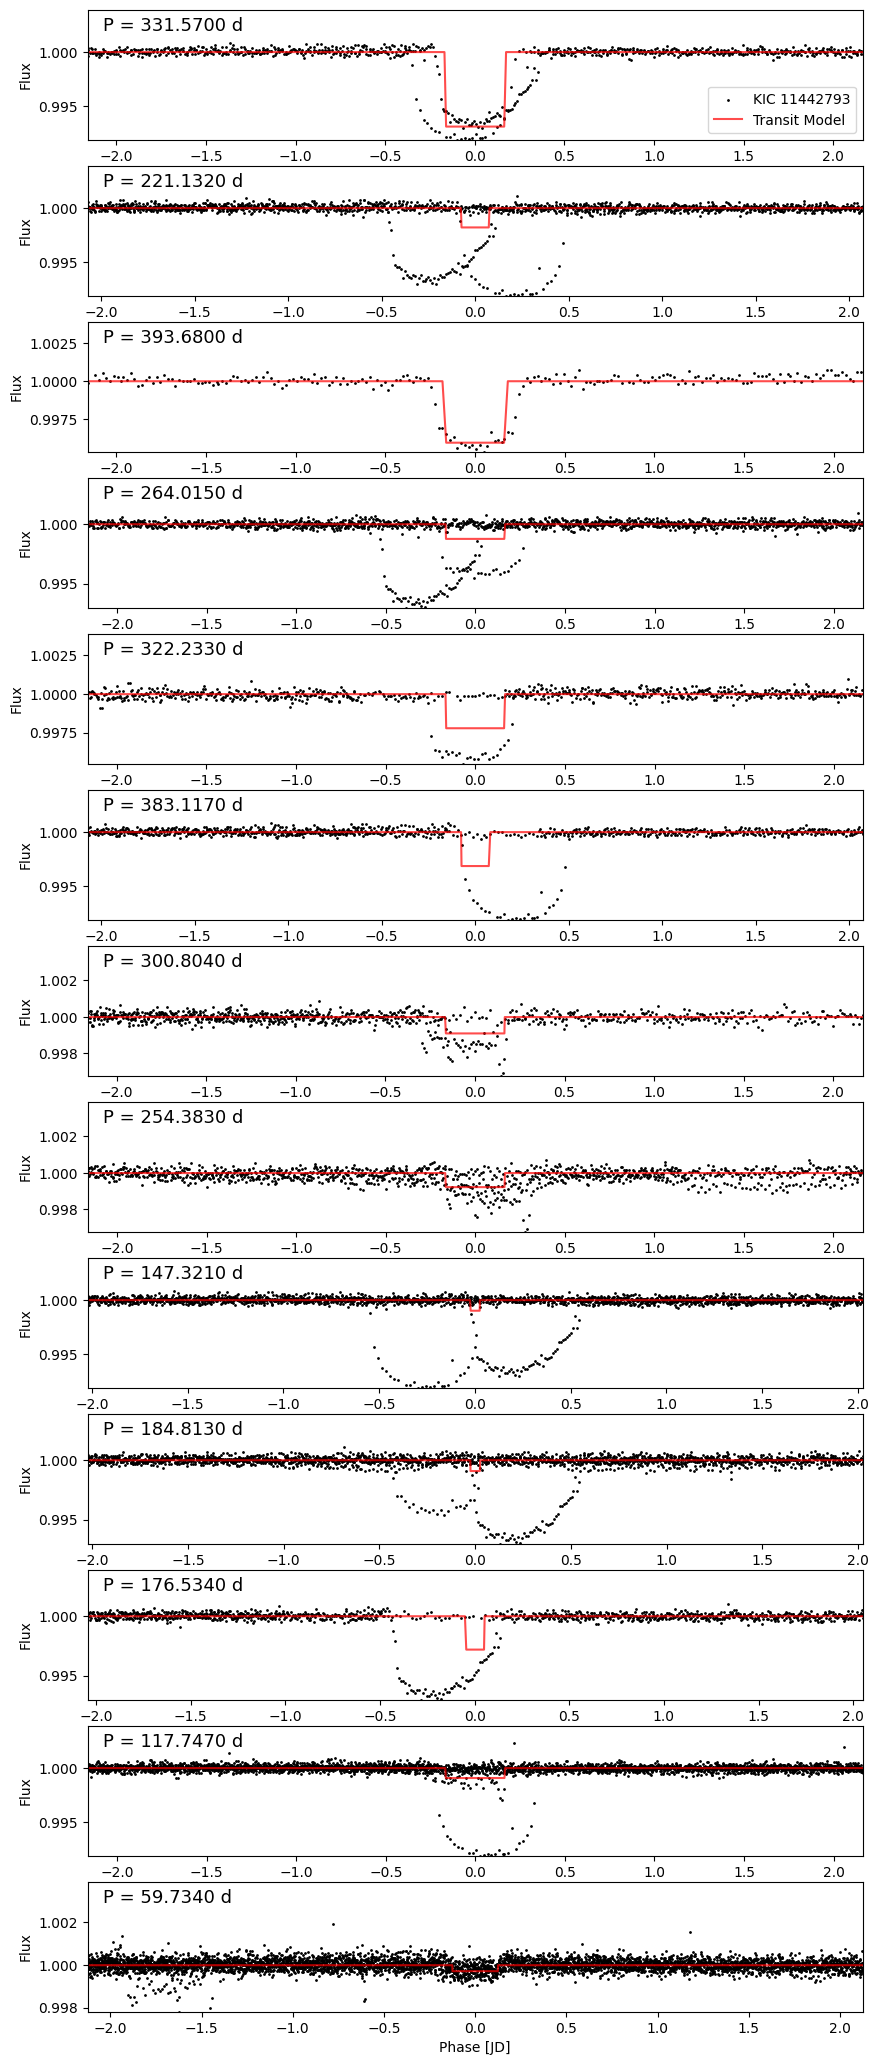

In [25]:
# YOUR CODE HERE

n = len(final_period)
fig, ax = plt.subplots(n, 1, figsize=(10, 2*n))

for i in range(len(ax)):
    folded_lc = clc.fold(period=final_period[i]*u.d, epoch_time=final_tt[i][0])

    model = pg_tot.get_transit_model( period=final_period[i], duration=final_duration[i], transit_time=final_tt[i][0] )
    folded_model = model.fold(period=final_period[i]*u.d, epoch_time=final_tt[i][0])

    transit_mask = folded_model.flux.value < folded_model.flux[0].value
    min_time = folded_model.time[transit_mask].value.min()
    max_time = folded_model.time[transit_mask].value.max()
    x1 = min_time-2
    x2 = max_time+2

    transit_mask2 = (folded_lc.time.value > x1) & (folded_lc.time.value < x2)
    y1 = np.nanmin(folded_lc.flux[transit_mask2].value)

    folded_lc.scatter(ax=ax[i], color='k');

    folded_model.plot(ax=ax[i], color='r', label='Transit Model', lw=1.5, alpha=.7);

    if i != len(ax)-1:
        ax[i].set_xlabel('')

    ax[i].get_legend().remove()

    ax[i].text( .02, .95, 'P = {:.4f} d'.format(final_period[i]), transform=ax[i].transAxes, va='top', ha='left', fontsize=13 )

    ax[i].set_xlim(x1, x2)
    ax[i].set_ylim(bottom=y1)

ax[0].legend(loc='lower right')

plt.show()